# SMAD2

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


In [2]:
gene_symbol = 'SMAD2'
mane_tx_id = 'NM_005901.6'
mane_protein_id = 'NP_005892.1' # mothers against decapentaplegic homolog 2 isoform 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = gene_symbol

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.21') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))


print(f'Loaded {len(phenopackets)} phenopackets')

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 23 phenopackets
Individuals Processed: 100%|██████████| 23/23 [00:00<00:00, 304.72individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Thoracic aortic aneurysm,HP:0012727,10
Scoliosis,HP:0002650,7
Arthralgia,HP:0002829,7
High palate,HP:0000218,7
Arachnodactyly,HP:0001166,6
Atrial septal defect,HP:0001631,5
Double outlet right ventricle,HP:0001719,5
Inguinal hernia,HP:0000023,5
Bruising susceptibility,HP:0000978,5
Tall stature,HP:0000098,5


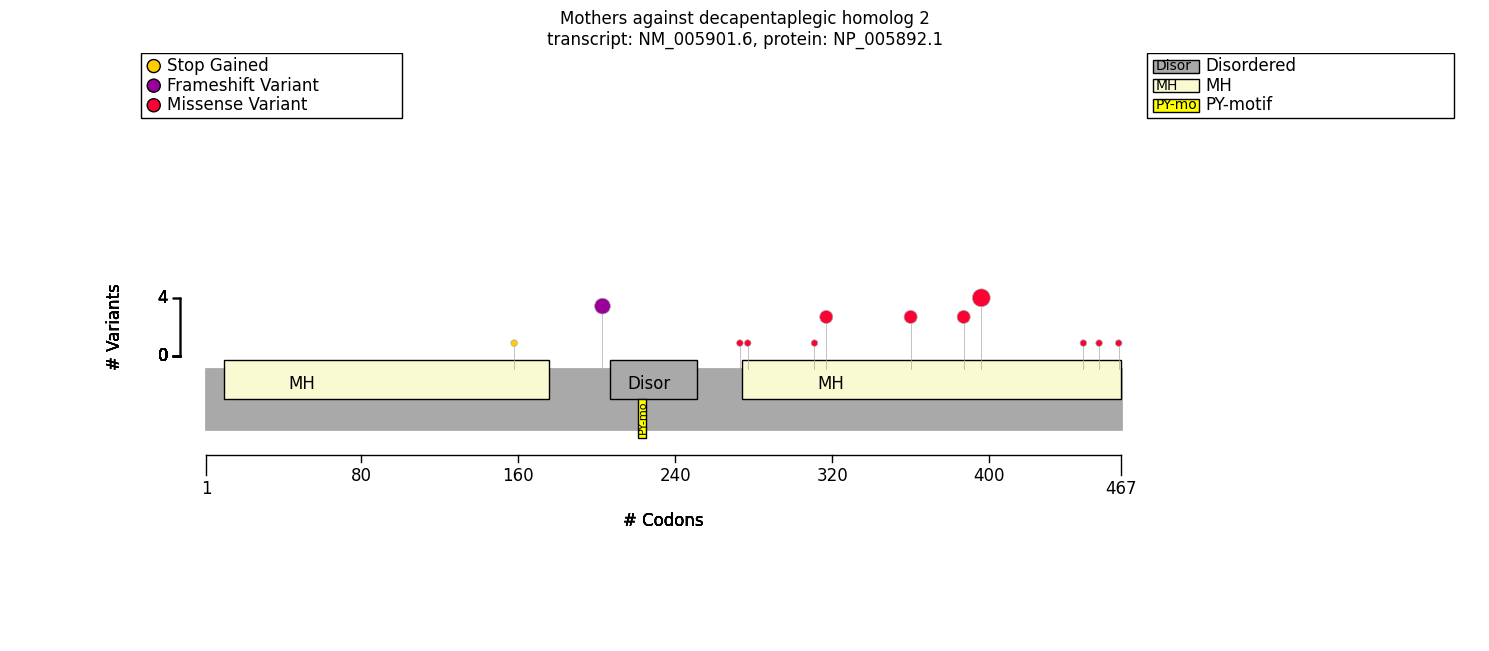

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
smad2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
smad2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis
We were not able to identify published results suggesting correlations with specific SMAD2 residues or variant categories.

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.view import MtcStatsViewer



ser397tyr = VariantPredicates.variant_key("18_47845430_47845430_G_T") #c.1190C>A	p.Ser397Tyr
ser397tyr_predicate = monoallelic_predicate(
    a_predicate=ser397tyr,
    b_predicate=~ser397tyr,
    a_label="Ser397Tyr",
    b_label="Other"
)
ser397tyr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=ser397tyr_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(ser397tyr_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,29
HMF05,Skipping term because one genotype had zero observations,1
HMF08,Skipping general term,70
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,176


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, ser397tyr_result)

Allele group                                       Ser397Tyr          Other  \
                                                       Count Percent  Count   
Hypertelorism [HP:0000316]                               3/4     75%   1/10   
Scoliosis [HP:0002650]                                   0/4      0%   7/10   
Arachnodactyly [HP:0001166]                              0/4      0%   6/10   
Thoracic aortic aneurysm [HP:0012727]                    1/4     25%   9/12   
Inguinal hernia [HP:0000023]                             0/3      0%    5/8   
Abnormal sternum morphology [HP:0000766]                 0/4      0%   5/11   
Pes planus [HP:0001763]                                  0/2      0%    4/9   
Varicose veins [HP:0002619]                              2/4     50%    2/8   
Arthralgia [HP:0002829]                                  2/4     50%    5/7   
Abnormal morphology of the great vessels [HP:00...       1/1    100%  16/16   
Abnormal blood vessel morphology [HP:0033353]            3/3    100%  19/19   
Abnormal axial skeleton morphology [HP:0009121]          1/1    100%  11/11   
Aortic aneurysm [HP:0004942]                             1/1    100%    9/9   
Vascular dilatation [HP:0002617]                         2/2    100%    9/9   
Abnormal aortic morphology [HP:0001679]                  1/1    100%  11/11   
Abnormal systemic arterial morphology [HP:0011004]       2/2    100%  14/14   
Tall stature [HP:0000098]                                1/3     33%    4/7   
Migraine [HP:0002076]                                    2/4     50%    3/6   
High palate [HP:0000218]                                 1/4     25%   6/14   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hypertelorism [HP:0000316]                             10%           0.537796   
Scoliosis [HP:0002650]                                 70%           0.537796   
Arachnodactyly [HP:0001166]                            60%           0.537796   
Thoracic aortic aneurysm [HP:0012727]                  75%           0.561126   
Inguinal hernia [HP:0000023]                           62%           0.690909   
Abnormal sternum morphology [HP:0000766]               45%           0.730769   
Pes planus [HP:0001763]                                44%           1.000000   
Varicose veins [HP:0002619]                            25%           1.000000   
Arthralgia [HP:0002829]                                71%           1.000000   
Abnormal morphology of the great vessels [HP:00...    100%           1.000000   
Abnormal blood vessel morphology [HP:0033353]         100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Aortic aneurysm [HP:0004942]                          100%           1.000000   
Vascular dilatation [HP:0002617]                      100%           1.000000   
Abnormal aortic morphology [HP:0001679]               100%           1.000000   
Abnormal systemic arterial morphology [HP:0011004]    100%           1.000000   
Tall stature [HP:0000098]                              57%           1.000000   
Migraine [HP:0002076]                                  50%           1.000000   
High palate [HP:0000218]                               43%           1.000000   

Allele group                                                  
                                                    p values  
Hypertelorism [HP:0000316]                          0.040959  
Scoliosis [HP:0002650]                              0.069930  
Arachnodactyly [HP:0001166]                         0.084915  
Thoracic aortic aneurysm [HP:0012727]               0.118132  
Inguinal hernia [HP:0000023]                        0.181818  
Abnormal sternum morphology [HP:0000766]            0.230769  
Pes planus [HP:0001763]                             0.490909  
Varicose veins [HP:0002619]                         0.547475  
Arthralg

In [10]:
from gpsea.model.genome import Region

nterm = VariantPredicates.region(region=Region(1,350), tx_id=mane_tx_id)
nterm_predicate = monoallelic_predicate(
    a_predicate=nterm,
    b_predicate=~nterm,
    a_label="N Term",
    b_label="Other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=nterm_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, nterm_result)


Allele group                                       N Term          Other  \
                                                    Count Percent  Count   
Arachnodactyly [HP:0001166]                           4/4    100%   2/10   
Thoracic aortic aneurysm [HP:0012727]                 5/5    100%   5/11   
Arthralgia [HP:0002829]                               0/2      0%    7/9   
Tall stature [HP:0000098]                             4/5     80%    1/5   
High palate [HP:0000218]                              4/7     57%   3/11   
Scoliosis [HP:0002650]                                2/2    100%   5/12   
Pes planus [HP:0001763]                               0/2      0%    4/9   
Varicose veins [HP:0002619]                           0/2      0%   4/10   
Dolichocephaly [HP:0000268]                           2/5     40%    1/6   
Abnormal morphology of the great vessels [HP:00...    8/8    100%    9/9   
Abnormal blood vessel morphology [HP:0033353]         9/9    100%  13/13   
Abnormal axial skeleton morphology [HP:0009121]       4/4    100%    8/8   
Abnormality of the vertebral column [HP:0000925]      3/3    100%    7/7   
Aortic aneurysm [HP:0004942]                          5/5    100%    5/5   
Vascular dilatation [HP:0002617]                      5/5    100%    6/6   
Abnormal aortic morphology [HP:0001679]               5/5    100%    7/7   
Abnormal systemic arterial morphology [HP:0011004]    6/6    100%  10/10   
Inguinal hernia [HP:0000023]                          1/2     50%    4/9   
Migraine [HP:0002076]                                 1/2     50%    4/8   

Allele group                                                                   \
                                                   Percent Corrected p values   
Arachnodactyly [HP:0001166]                            20%           0.284715   
Thoracic aortic aneurysm [HP:0012727]                  45%           0.690909   
Arthralgia [HP:0002829]                                78%           0.690909   
Tall stature [HP:0000098]                              20%           0.980159   
High palate [HP:0000218]                               27%           1.000000   
Scoliosis [HP:0002650]                                 42%           1.000000   
Pes planus [HP:0001763]                                44%           1.000000   
Varicose veins [HP:0002619]                            40%           1.000000   
Dolichocephaly [HP:0000268]                            17%           1.000000   
Abnormal morphology of the great vessels [HP:00...    100%           1.000000   
Abnormal blood vessel morphology [HP:0033353]         100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormality of the vertebral column [HP:0000925]      100%           1.000000   
Aortic aneurysm [HP:0004942]                          100%           1.000000   
Vascular dilatation [HP:0002617]                      100%           1.000000   
Abnormal aortic morphology [HP:0001679]               100%           1.000000   
Abnormal systemic arterial morphology [HP:0011004]    100%           1.000000   
Inguinal hernia [HP:0000023]                           44%           1.000000   
Migraine [HP:0002076]                                  50%           1.000000   

Allele group                                                  
                                                    p values  
Arachnodactyly [HP:0001166]                         0.014985  
Thoracic aortic aneurysm [HP:0012727]               0.093407  
Arthralgia [HP:0002829]                             0.109091  
Tall stature [HP:0000098]                           0.206349  
High palate [HP:0000218]                            0.332202  
Scoliosis [HP:0002650]                              0.461538  
Pes planus [HP:0001763]                             0.490909  
Varicose veins [HP:0002619]                         0.515152  
Dolichocephaly [HP:0000268]                         0.545455  
Abnormal

In [11]:
from gpsea.analysis.predicate.genotype import sex_predicate

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, mf_result)


Sex                                                FEMALE          MALE  \
                                                    Count Percent Count   
Scoliosis [HP:0002650]                                3/9     33%   4/5   
Abnormal sternum morphology [HP:0000766]              2/9     22%   3/6   
Inguinal hernia [HP:0000023]                          3/8     38%   2/3   
Dolichocephaly [HP:0000268]                           2/5     40%   1/6   
Pes planus [HP:0001763]                               2/7     29%   2/4   
High palate [HP:0000218]                             6/13     46%   1/5   
Thoracic aortic aneurysm [HP:0012727]                 5/9     56%   5/7   
Abnormal morphology of the great vessels [HP:00...    8/8    100%   7/7   
Abnormal blood vessel morphology [HP:0033353]       12/12    100%   8/8   
Abnormal axial skeleton morphology [HP:0009121]       7/7    100%   5/5   
Abnormality of the vertebral column [HP:0000925]      5/5    100%   5/5   
Aortic aneurysm [HP:0004942]                          5/5    100%   5/5   
Vascular dilatation [HP:0002617]                      6/6    100%   5/5   
Abnormal aortic morphology [HP:0001679]               5/5    100%   7/7   
Abnormal systemic arterial morphology [HP:0011004]    8/8    100%   8/8   
Arachnodactyly [HP:0001166]                           4/9     44%   2/5   
Tall stature [HP:0000098]                             2/5     40%   3/5   
Migraine [HP:0002076]                                 4/9     44%   1/1   
Arthralgia [HP:0002829]                               6/9     67%   1/2   

Sex                                                                            \
                                                   Percent Corrected p values   
Scoliosis [HP:0002650]                                 80%                1.0   
Abnormal sternum morphology [HP:0000766]               50%                1.0   
Inguinal hernia [HP:0000023]                           67%                1.0   
Dolichocephaly [HP:0000268]                            17%                1.0   
Pes planus [HP:0001763]                                50%                1.0   
High palate [HP:0000218]                               20%                1.0   
Thoracic aortic aneurysm [HP:0012727]                  71%                1.0   
Abnormal morphology of the great vessels [HP:00...    100%                1.0   
Abnormal blood vessel morphology [HP:0033353]         100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Abnormality of the vertebral column [HP:0000925]      100%                1.0   
Aortic aneurysm [HP:0004942]                          100%                1.0   
Vascular dilatation [HP:0002617]                      100%                1.0   
Abnormal aortic morphology [HP:0001679]               100%                1.0   
Abnormal systemic arterial morphology [HP:0011004]    100%                1.0   
Arachnodactyly [HP:0001166]                            40%                1.0   
Tall stature [HP:0000098]                              60%                1.0   
Migraine [HP:0002076]                                 100%                1.0   
Arthralgia [HP:0002829]                                50%                1.0   

Sex                                                           
                                                    p values  
Scoliosis [HP:0002650]                              0.265734  
Abnormal sternum morphology [HP:0000766]            0.328671  
Inguinal hernia [HP:0000023]                        0.545455  
Dolichocephaly [HP:0000268]                         0.545455  
Pes planus [HP:0001763]                             0.575758  
High palate [HP:0000218]                            0.595588  
Thoracic aortic aneurysm [HP:0012727]               0.632867  
Abnormal morphology of the great vessels [HP:00...  1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000  
Abnormal axial skeleton morph

# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=ser397tyr_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "We were not able to identify published results suggesting correlations with specific SMAD2 residues or variant categories."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Ser397Tyr,Other,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
N Term,Other,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,19,0


In [14]:
summarizer.process_latex(report=report, protein_fig=smad2_fig)

Figure saved to ../../supplement/img/SMAD2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SMAD2_summary_draft.tex
